In [1]:
import datetime
import sys, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
sc.logging.print_memory_usage()
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi = 300, dpi_save = 300)
sc.logging.print_header()
from matplotlib.pyplot import rc_context

Memory usage: current 0.21 GB, difference +0.21 GB
scanpy==1.10.2 anndata==0.10.8 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.0.3 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [3]:
import decoupler as dc

In [4]:
# add the utility functions folder to PATH
sys.path.append(os.path.abspath("../packages"))
from db_dev.helper import *

In [5]:
import matplotlib as mpl
mpl.rc("font", family = "Arial")
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42


In [6]:
#load data with leiden
#home_dir = os.path.expanduser("~")
current_directory = os.getcwd()
adata = sc.read_h5ad(current_directory+"/backups/bb2_bb3_leiden_2.5_sub_DGE_refined_annotation_86447x37733_241107_10h51.h5ad")

In [7]:
#Loading obs
current_directory = os.getcwd()
# overwrite obs with the most recent version
filename = current_directory+"/backups/anno_obs_info_86447x39_250127_18h19.npz"
encoding = "latin1"

with np.load(filename, encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)

obs_cell_type_sub_prolif_anno = obs[["barcode", "library", "cell_type_sub_prolif_anno"]]

# Perform a left join
updated_obs = adata.obs.merge(obs_cell_type_sub_prolif_anno, on=["library", "barcode"], how="left")

# Update the adata.obs with the new annotations
adata.obs = updated_obs


In [11]:
# exclude patients with monocytic blasts

adata = adata[(adata.obs["code"] != "1-FM02-NP0000032") & (adata.obs["code"] != "1-FM02-NP0000045")].copy()


/Users/denis/mambaforge/envs/capseq_dge/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
#subset adata

select_cell_type = "CD16 Monocytes"


select_control_sample = "KC"
select_condition_sample = "UL"


select_sample = [
    select_condition_sample,
    select_control_sample
]
sample_mask = adata.obs["sample"].isin(select_sample)



In [13]:
adata = adata[sample_mask].copy()

In [16]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col = "sample_code",
    groups_col = "cell_type_sub_prolif_anno",
    layer = "counts",
    mode = "sum",
    min_cells = 10,
    min_counts = 1000
)
pdata

AnnData object with n_obs × n_vars = 205 × 31568
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo'
    layers: 'psbulk_props'

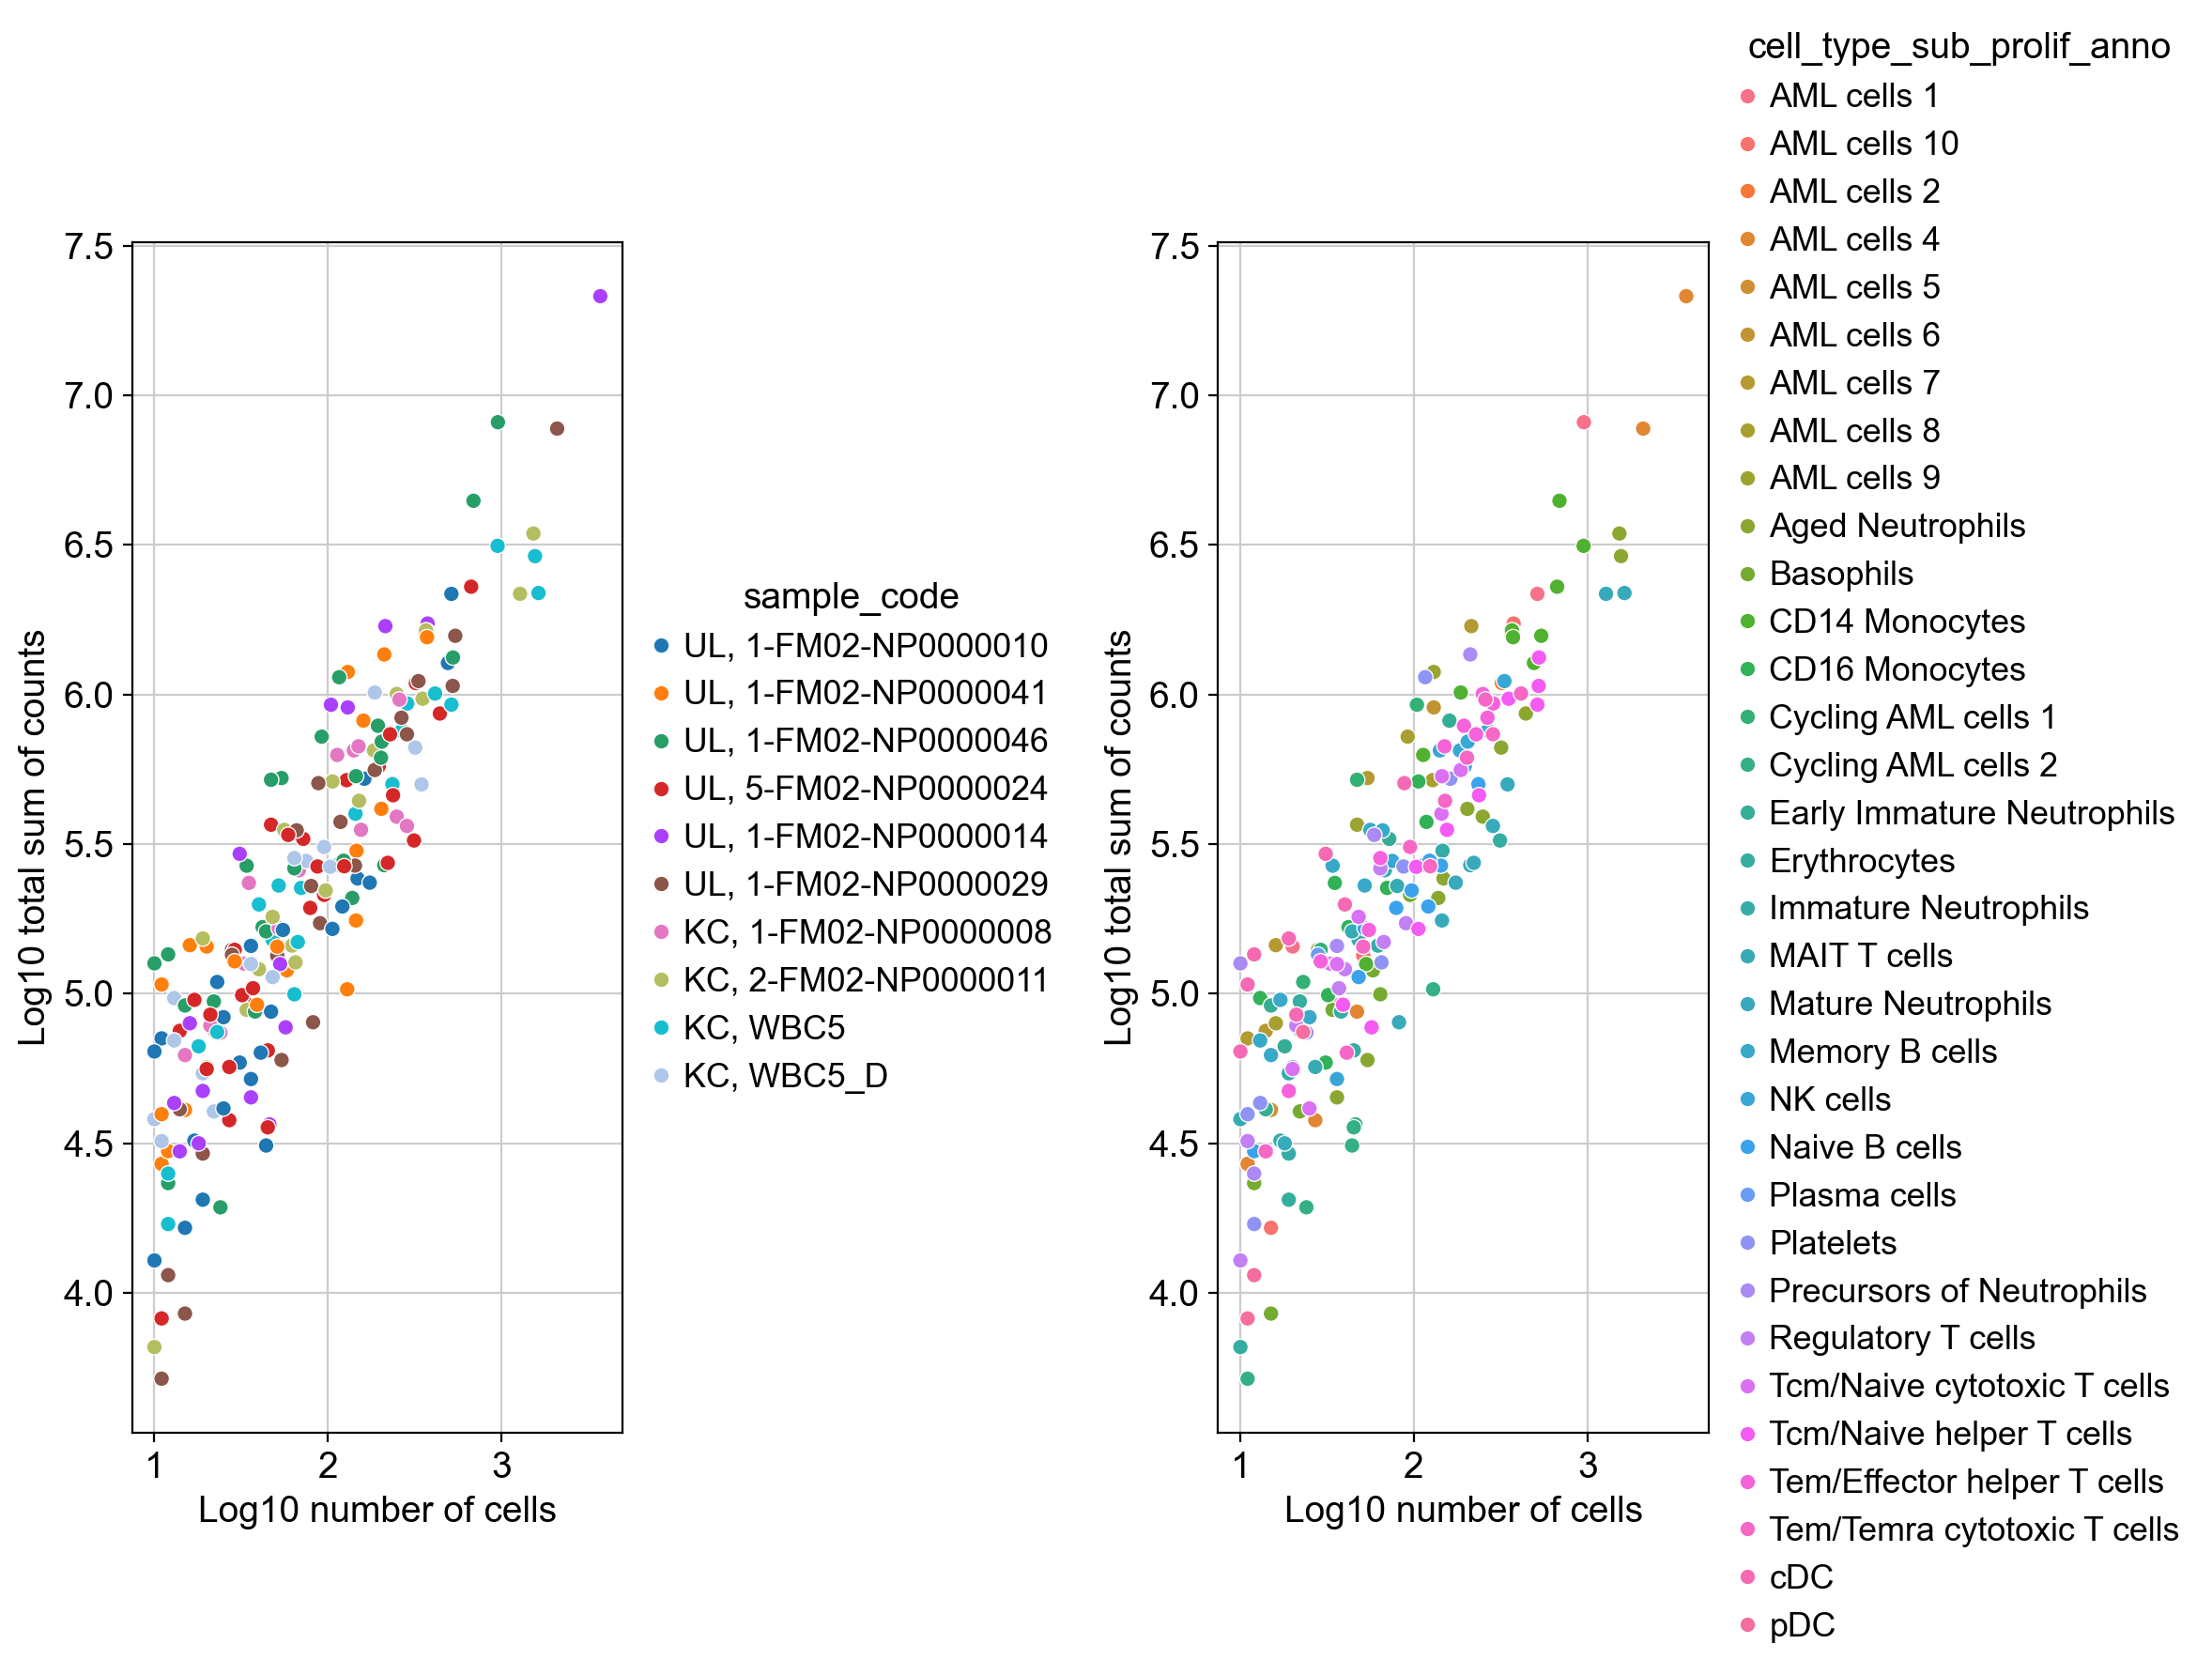

In [17]:
dc.plot_psbulk_samples(pdata, groupby=["sample_code", "cell_type_sub_prolif_anno"], figsize=(12, 9))

In [18]:
pdata

AnnData object with n_obs × n_vars = 205 × 31568
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo'
    layers: 'psbulk_props'

In [19]:
# Store raw counts in layers
pdata.layers["counts"] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum = 1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value = 10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, "counts", X_layer_key=None, inplace=True)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


In [20]:
pdata

AnnData object with n_obs × n_vars = 205 × 31568
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [21]:
# Select CD16 Monocytes profiles
print(select_cell_type)
cd16_monocytes = pdata[pdata.obs["cell_type_sub_prolif_anno"] == select_cell_type].copy()

CD16 Monocytes


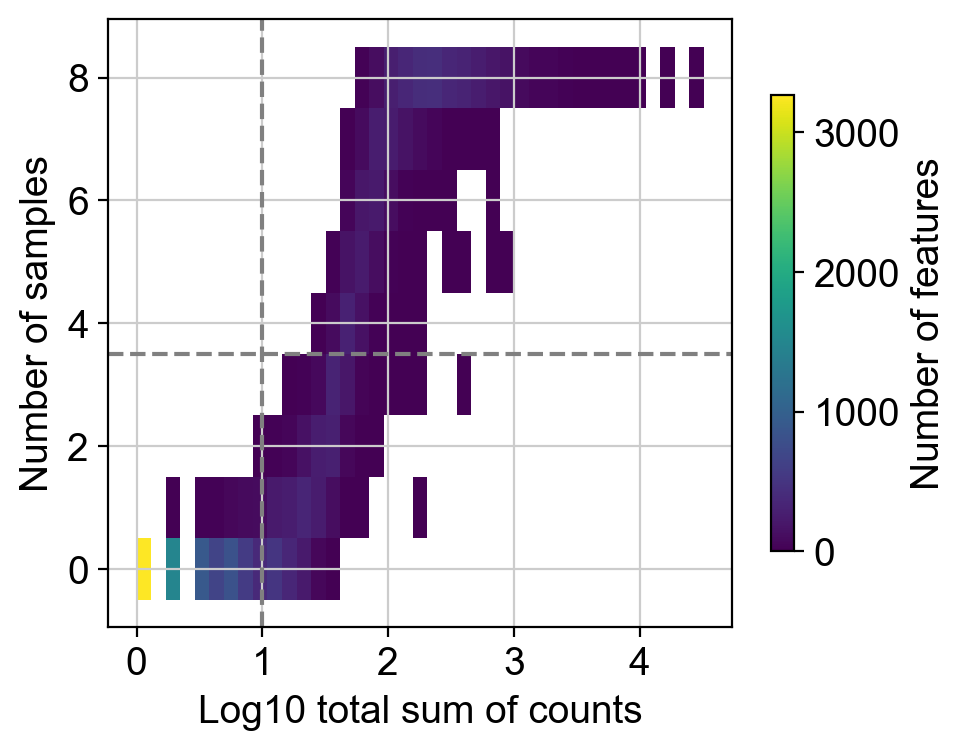

In [22]:
dc.plot_filter_by_expr(cd16_monocytes, group = "sample", min_count = 5, min_total_count = 10)



In [23]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(cd16_monocytes, group = "sample", min_count = 5, min_total_count = 10)

# Filter by these genes
cd16_monocytes = cd16_monocytes[:, genes].copy()
cd16_monocytes


AnnData object with n_obs × n_vars = 8 × 5770
    obs: 'sample_code', 'sample', 'code', 'cell_type_sub_prolif_anno', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mt', 'ribo', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [24]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [25]:
cd16_monocytes.obs["sample"].unique()

array(['KC', 'UL'], dtype=object)

In [26]:
# Build DESeq2 object
inference = DefaultInference(n_cpus = 8)
dds = DeseqDataSet(
    adata = cd16_monocytes,
    design_factors = "sample",
    ref_level = ["sample", select_control_sample],
    refit_cooks = True,
    inference = inference,
)

In [27]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.73 seconds.

Fitting dispersion trend curve...
... done in 0.08 seconds.

Fitting MAP dispersions...
... done in 0.72 seconds.

Fitting LFCs...
... done in 0.35 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [28]:
# Extract contrast between AML vs HD
stat_res = DeseqStats(
    dds,
    contrast=["sample", select_condition_sample, select_control_sample],
    inference = inference,
)

In [29]:
# Compute Wald test
stat_res.summary()

Running Wald tests...
... done in 0.16 seconds.



Log2 fold change & Wald test p-value: sample UL vs KC
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AAGAB     15.946787       -0.246274  0.484486 -0.508320  0.611229  0.981396
AAK1      35.093116        0.615929  0.357343  1.723635  0.084774  0.798995
AAMDC      4.040578        0.158471  0.810848  0.195439  0.845049       NaN
AASDHPPT   5.591695        0.088341  0.759696  0.116285  0.907427       NaN
AATBC      7.636806       -0.732743  0.597790 -1.225753  0.220291  0.904418
...             ...             ...       ...       ...       ...       ...
ZXDC      20.013238        0.446236  0.413550  1.079038  0.280571  0.936303
ZYG11B    10.169144       -0.865887  0.529836 -1.634254  0.102206  0.821631
ZYX       37.534518        0.090711  0.382875  0.236919  0.812719  0.995079
ZZEF1     38.818240        0.217313  0.316074  0.687540  0.491742  0.963937
ZZZ3      14.649951        0.173832  0.434218  0.400333  0.688911  0.983655

[5770 rows x 6 columns]


In [31]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AAGAB,15.946787,-0.246274,0.484486,-0.508320,0.611229,0.981396
AAK1,35.093116,0.615929,0.357343,1.723635,0.084774,0.798995
AAMDC,4.040578,0.158471,0.810848,0.195439,0.845049,NaN
AASDHPPT,5.591695,0.088341,0.759696,0.116285,0.907427,NaN
AATBC,7.636806,-0.732743,0.597790,-1.225753,0.220291,0.904418
...,...,...,...,...,...,...
ZXDC,20.013238,0.446236,0.413550,1.079038,0.280571,0.936303
ZYG11B,10.169144,-0.865887,0.529836,-1.634254,0.102206,0.821631
ZYX,37.534518,0.090711,0.382875,0.236919,0.812719,0.995079
ZZEF1,38.818240,0.217313,0.316074,0.687540,0.491742,0.963937


In [32]:
# Export volcano genes
results_df.to_csv("dge/pseudobulk_volcano_cd16_monocytes_AML_vs_HD_patient_5and7_excluded.csv")


results_df_sorted = results_df.copy()
results_df_sorted[results_df_sorted["padj"] < 0.05].sort_values(by = "log2FoldChange", ascending=False, key=abs).to_excel("dge/pseudobulk_volcano_cd16_monocytes_AML_vs_HD_patient_5and7_excluded_filtered_by_padj.xlsx")



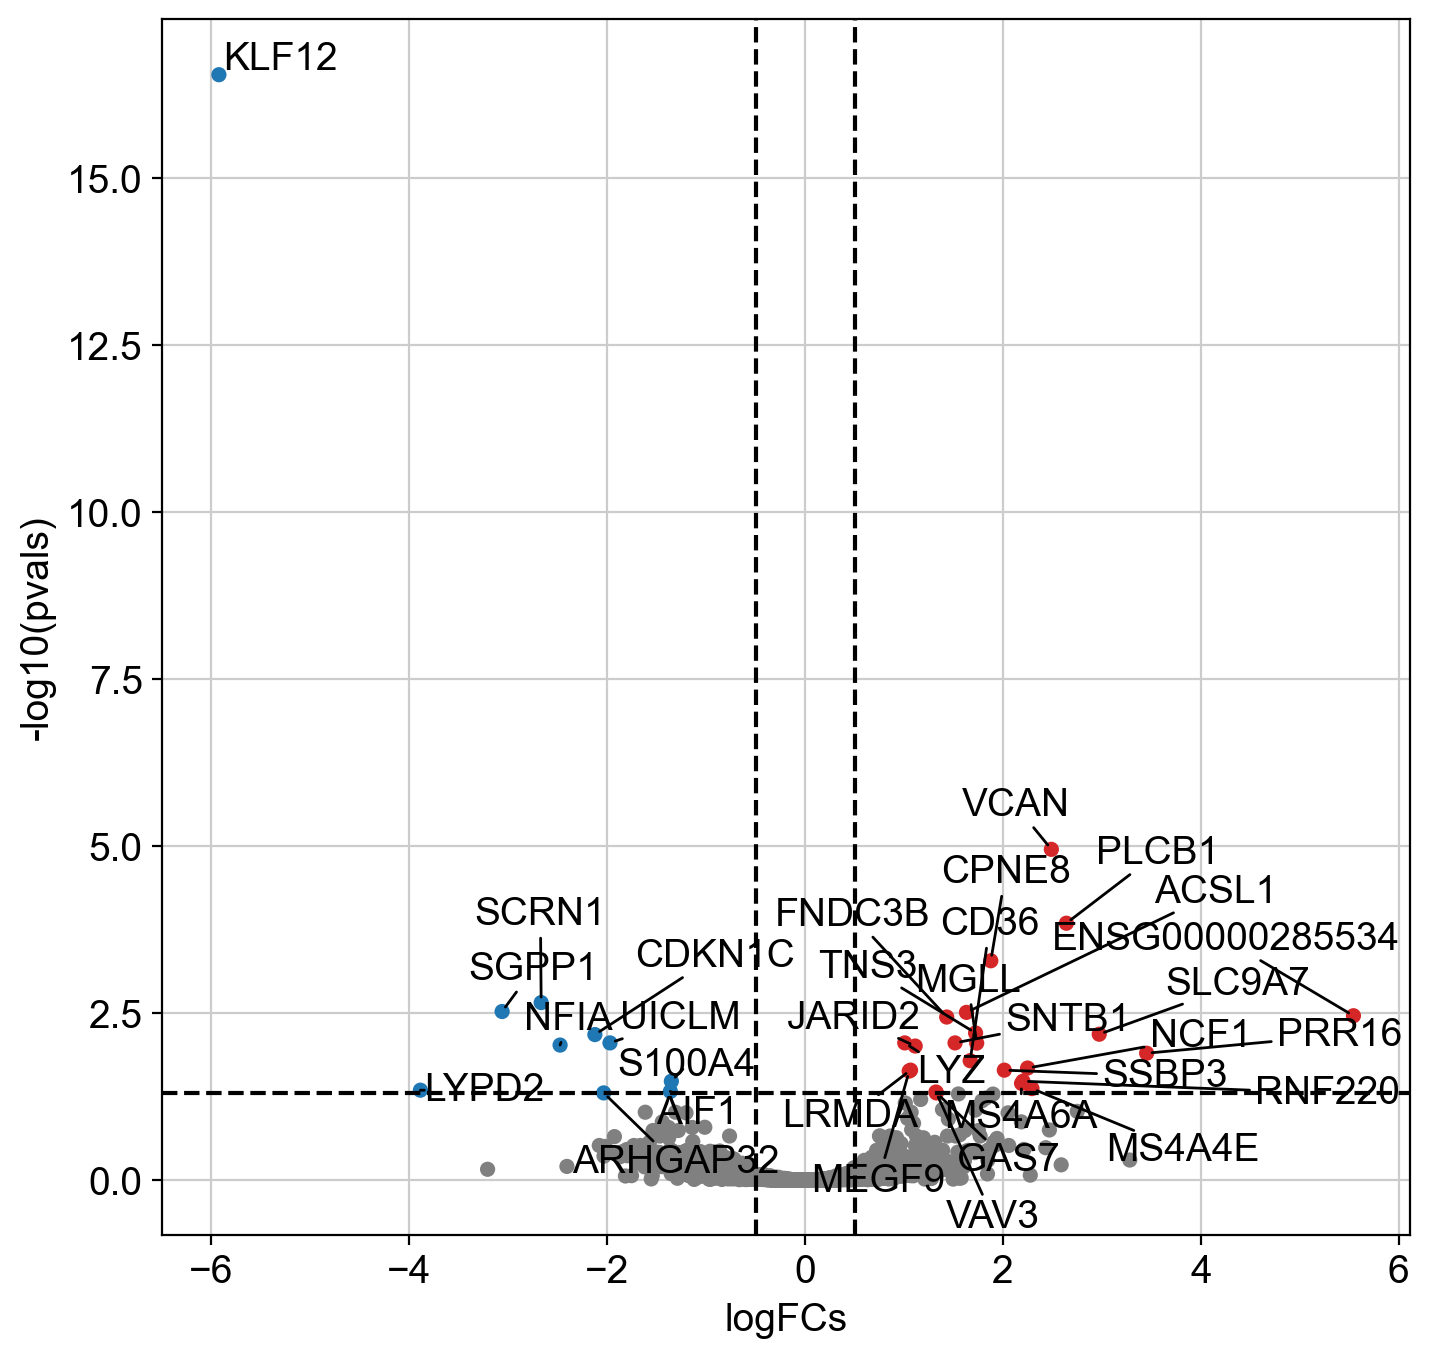

In [8]:
fig = dc.plot_volcano_df(
    results_df,
    x = "log2FoldChange",
    y = "padj",
    top = 50,
    figsize = (8, 8), return_fig = True
)


In [8]:
print(select_cell_type)
mat = results_df[["stat"]].T.rename(index={"stat": select_cell_type})
mat

CD16 Monocytes


,AAGAB,AAK1,AAMDC,AASDHPPT,AATBC,AATF,ABAT,ABCA1,ABCA7,ABCB10,...,ZRSR2,ZSCAN16-AS1,ZSWIM6,ZSWIM7,ZUP1,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
CD16 Monocytes,-0.50832,1.723635,0.195439,0.116285,-1.225753,0.849293,0.689913,0.813591,0.441048,-0.451522,...,1.518873,1.021055,1.705731,0.074578,0.058963,1.079038,-1.634254,0.236919,0.68754,0.400333


# ORA

In [11]:
# Retrieve MSigDB resource
msigdb = dc.get_resource('MSigDB')
msigdb

,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP
...,...,...,...
3838543,PRAMEF22,go_biological_process,GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...
3838544,PRAMEF22,go_biological_process,GOBP_APOPTOTIC_PROCESS
3838545,PRAMEF22,go_biological_process,GOBP_REGULATION_OF_CELL_DEATH
3838546,PRAMEF22,go_biological_process,GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS


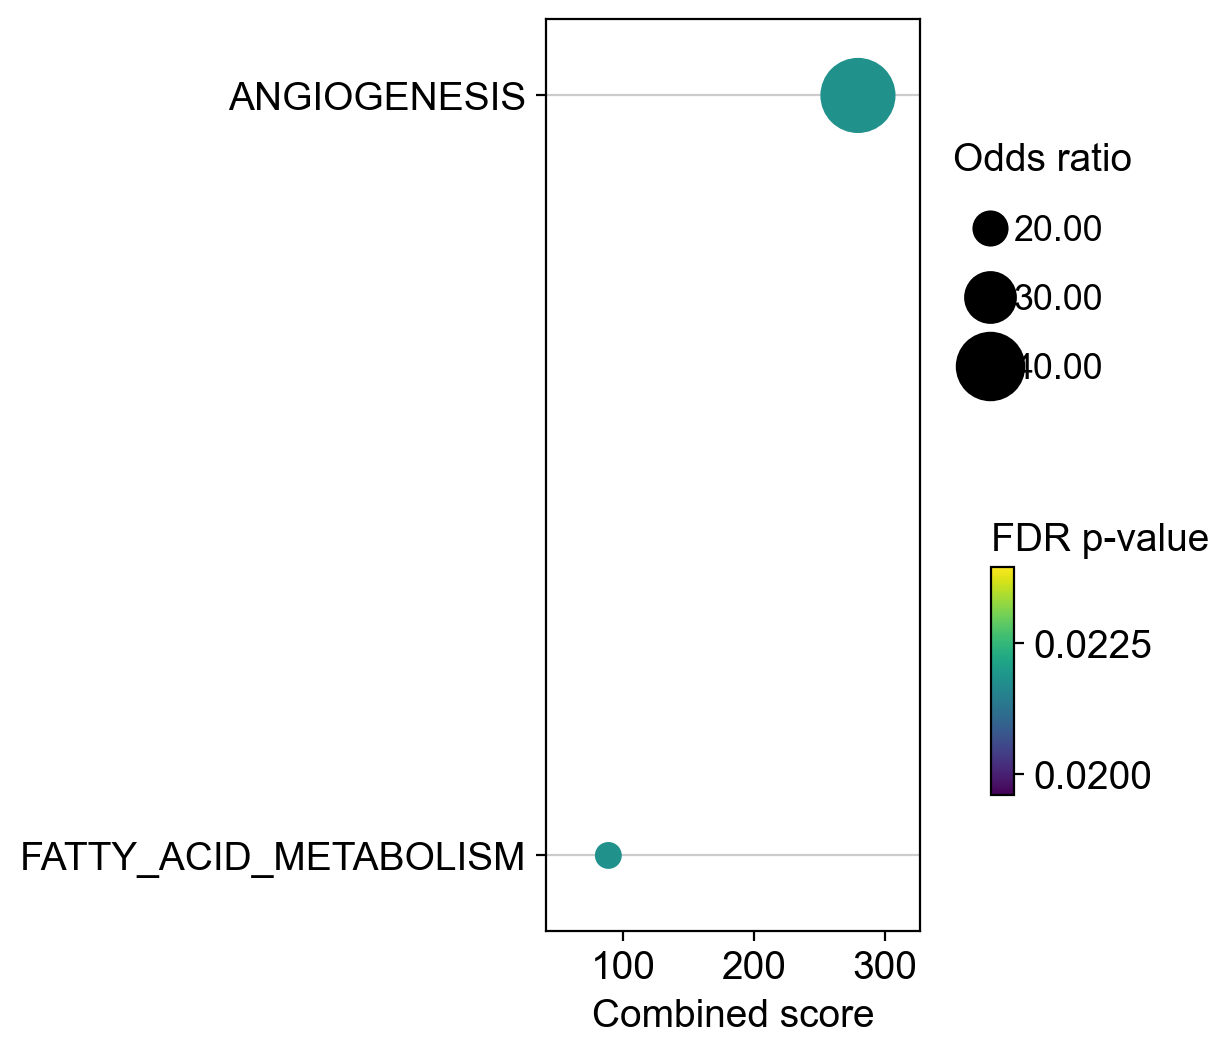

In [15]:
# Filter by hallmark
msigdb_filtered = msigdb[msigdb["collection"]=="hallmark"]

# Remove duplicated entries
msigdb_filtered = msigdb_filtered[~msigdb_filtered.duplicated(["geneset", "genesymbol"])]

# Rename
msigdb_filtered.loc[:, "geneset"] = [name.split("HALLMARK_")[1] for name in msigdb_filtered["geneset"]]

msigdb_filtered



# COMBINED

try:
    
    # Infer enrichment with ora using significant deg
    top_genes = results_df[(results_df["padj"] < 0.05)]

    # Run ora
    enr_pvals = dc.get_ora_df(
        df = top_genes,
        net = msigdb_filtered,
        source = "geneset",
        target = "genesymbol"
    )
    
    enr_pvals_select = enr_pvals[(enr_pvals["FDR p-value"] < 0.05)].sort_values("Combined score", ascending=False)
    
    dc.plot_dotplot(
        enr_pvals_select,
        x = "Combined score",
        y = "Term",
        s = "Odds ratio", 
        c = "FDR p-value",
        cmap = "viridis",
        scale = 0.1,
        figsize=(3, 6)
    )

except Exception as e:
    print(f"Error ignored: {e}")


# GSEA

In [16]:
gsea_hallmark = dc.get_gsea_df(results_df, stat = "stat", net = msigdb_filtered, source="geneset", target="genesymbol")

In [17]:
gsea_hallmark.to_excel("gsea/gsea_cd16_monocytes.xlsx")

In [18]:
gsea_hallmark.sort_values(by = "FDR p-value").head(10)

,Term,ES,NES,NOM p-value,FDR p-value,Set size,Tag %,Rank %,Leading edge
31,MYC_TARGETS_V1,-0.451778,-2.077441,0.000000,0.000000,139,0.496403,0.286828,H2AZ1;PSMA4;RPL14;SNRPD2;SSBP1;EIF4G2;PSMD8;PP...
35,OXIDATIVE_PHOSPHORYLATION,-0.466562,-2.134400,0.000000,0.000000,131,0.412214,0.217331,GPI;NDUFA7;MFN2;UQCRB;COX8A;ATP6V1G1;CYB5R3;AT...
30,MTORC1_SIGNALING,-0.353264,-1.582412,0.002141,0.035689,117,0.367521,0.212998,GPI;CORO1A;GGA2;PSMA4;RDH11;PPIA;ATP2A2;PRDX1;...
47,UV_RESPONSE_UP,-0.355790,-1.420848,0.036325,0.343811,65,0.323077,0.214038,CDC5L;SOD2;JUNB;RPN1;AP2S1;PLCL1;RHOB;BTG1;HMO...
41,REACTIVE_OXYGEN_SPECIES_PATHWAY,-0.424401,-1.459250,0.041257,0.343811,31,0.516129,0.306239,LAMTOR5;PRDX1;SOD2;JUNB;SELENOS;HHEX;PTPA;GPX4...
20,HEME_METABOLISM,0.328242,1.374337,0.040153,0.343811,88,0.329545,0.240381,TOP1;RANBP10;FOXO3;NEK7;CTSB;LPIN2;BLVRB;GMPS;...
49,XENOBIOTIC_METABOLISM,-0.315506,-1.294120,0.065678,0.364878,64,0.312500,0.187175,CSAD;ATP2A2;GCNT2;HACL1;CYFIP2;SAR1B;MCCC2;ABC...
12,E2F_TARGETS,-0.313038,-1.316423,0.059671,0.364878,77,0.506494,0.344367,NUP107;H2AZ1;NUDT21;DDX39A;RAN;LYAR;EIF2S1;HNR...
21,HYPOXIA,-0.312377,-1.323521,0.055319,0.364878,81,0.185185,0.071404,IDS;PFKL;TPI1;TPST2;HMOX1;MT2A;GAA;PRDX5;TGFBI...
37,PANCREAS_BETA_CELLS,-0.529593,-1.345325,0.130522,0.487918,10,0.200000,0.037088,MAFB;AKT3


MYC_TARGETS_V1
OXIDATIVE_PHOSPHORYLATION
MTORC1_SIGNALING


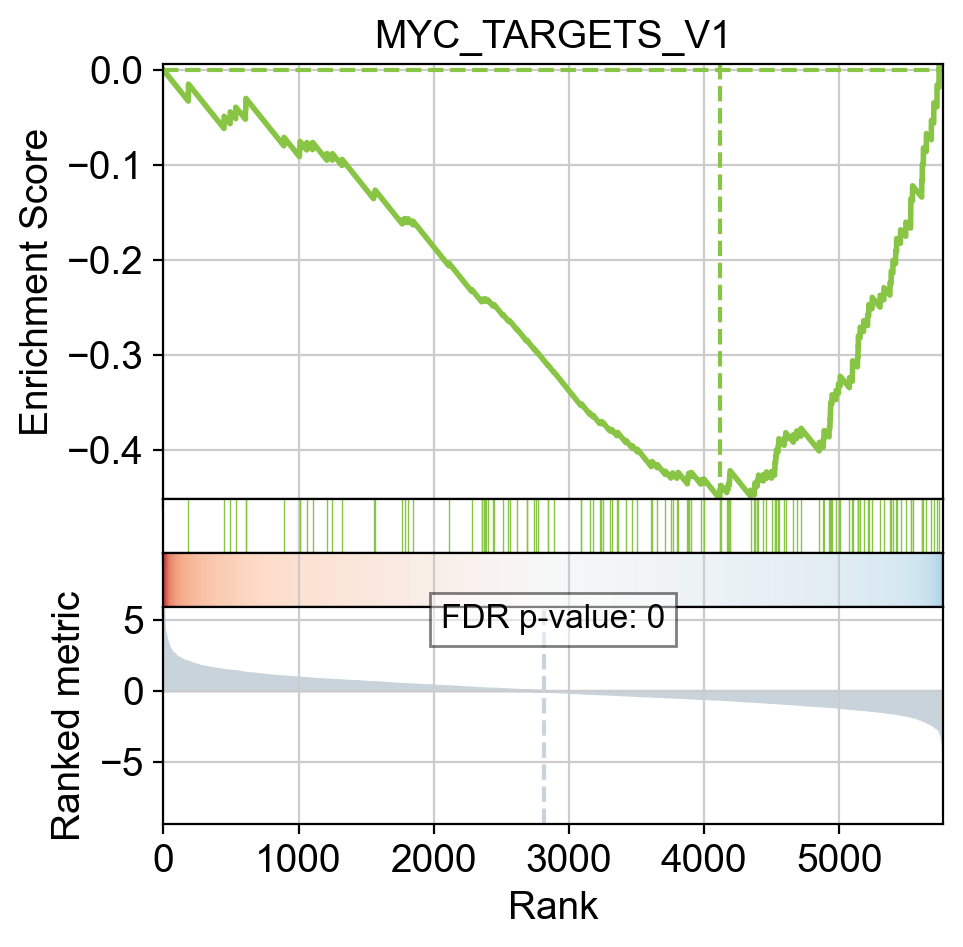

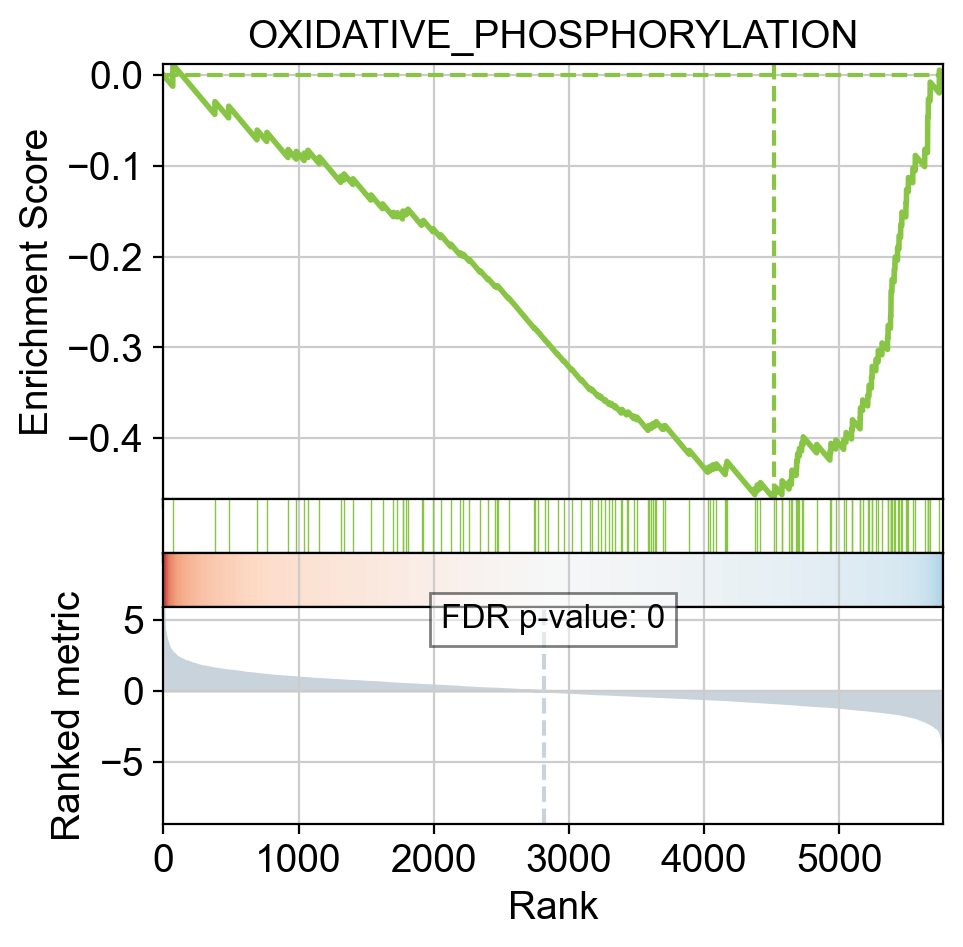

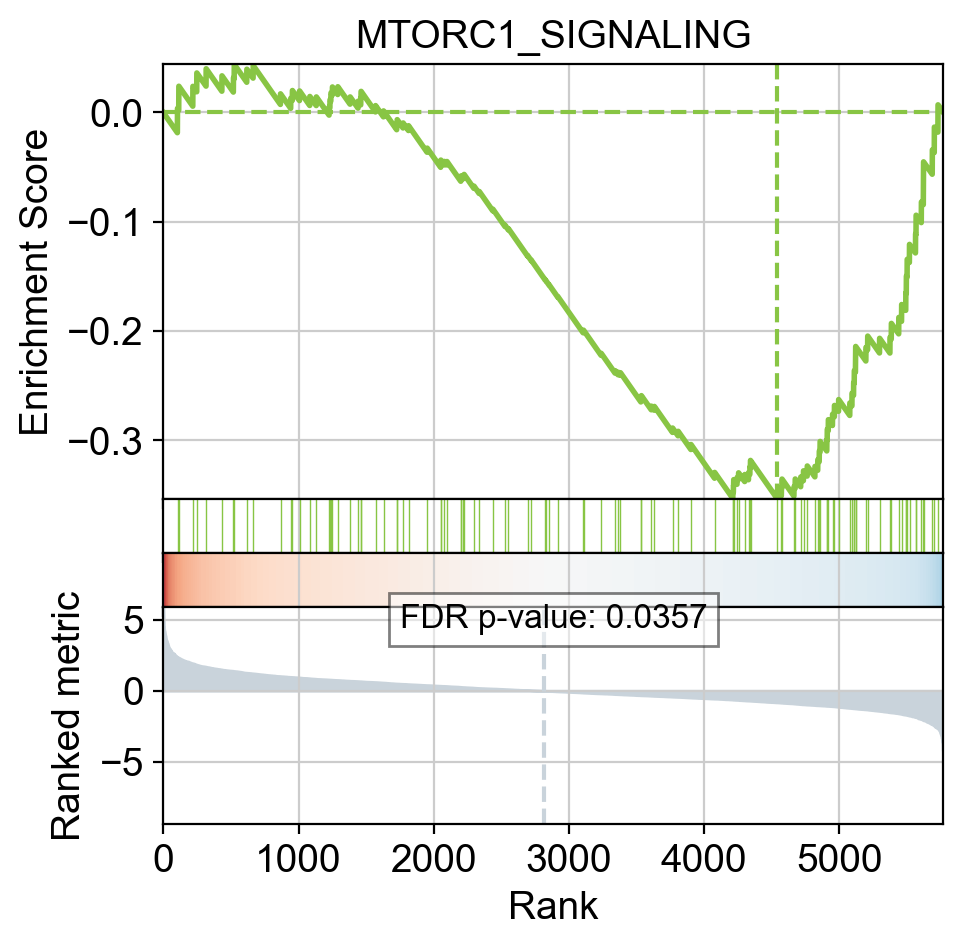

In [19]:
import matplotlib.pyplot as plt

selected_terms = ["MYC_TARGETS_V1", "OXIDATIVE_PHOSPHORYLATION", "MTORC1_SIGNALING"]


for set_name in selected_terms:
    print(set_name)

    # Extract FDR p-value
    fdr_pval = gsea_hallmark.loc[gsea_hallmark['Term'] == set_name, 'FDR p-value'].values
    if len(fdr_pval) > 0:
        fdr_pval_text = f"FDR p-value: {fdr_pval[0]:.3g}"
    else:
        fdr_pval_text = "FDR p-value: N/A"

    # Create the plot
    fig = dc.plot_running_score(
        df=results_df,
        stat='stat',
        net=msigdb_filtered,
        source='geneset',
        target='genesymbol',
        set_name=set_name,
        return_fig = True
    )

    #ax = fig[0].gca()

    axes = fig[0].get_axes()  # Get all subplots
    main_ax = axes[3]  # Assuming the first subplot is the main enrichment score plot


    # Get axis limits dynamically
    xlim = main_ax.get_xlim()
    ylim = main_ax.get_ylim()
    x_center = (xlim[0] + xlim[1]) / 2
    y_center = 5#(ylim[0] + ylim[1]) / 2

    # Add text annotation at the center
    main_ax.text(x_center, y_center, fdr_pval_text, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))


    #Save the figure
    plt.savefig(f"figures/final/gsea/pseudobulk_cd16_monocytes_AML_vs_HD_{set_name}.pdf")
    #plt.close(fig)
